# Non-Fungible Tokens: Empirical Asset Pricing with Machine Learning

In [53]:
#from google.colab import drive
#drive.mount('/content/drive')

## Setup

In [54]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
from sklearn import preprocessing
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error,r2_score
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

## Data Extraction

In [55]:
# Excel
df_trends = pd.read_excel('data/google_trends.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_tokens = pd.read_excel('data/df_tokens.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_collection = pd.read_excel('data/nonfungible-art-blocks.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_market = pd.read_excel('data/nonfungible-market.xlsx', usecols=lambda x: 'Unnamed' not in x) 

# CSV
df_provenance = pd.read_csv('data/df_provenance.csv', usecols=lambda x: 'Unnamed' not in x) 
df_traits = pd.read_csv('data/df_traits.csv', usecols=lambda x: 'Unnamed' not in x) 
df_txn = pd.read_csv('data/df_txn.csv', usecols=lambda x: 'Unnamed' not in x) 
df_eth = pd.read_csv('data/ETH-USD.csv', usecols=lambda x: 'Unnamed' not in x) 
df_tokens_minted = pd.read_csv('data/tokens_minted.csv', usecols=lambda x: 'Unnamed' not in x)

df_makert_cap = pd.read_excel('data/market_cap.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_floor_price = pd.read_excel('data/floor_price.xlsx', usecols=lambda x: 'Unnamed' not in x) 

In [56]:
'''# Excel
df_trends = pd.read_excel('/content/drive/MyDrive/Tese/data/google_trends.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_tokens = pd.read_excel('/content/drive/MyDrive/Tese/data/df_tokens.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_collection = pd.read_excel('/content/drive/MyDrive/Tese/data/nonfungible-art-blocks.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_market = pd.read_excel('/content/drive/MyDrive/Tese/data/nonfungible-market.xlsx', usecols=lambda x: 'Unnamed' not in x) 

# CSV
df_provenance = pd.read_csv('/content/drive/MyDrive/Tese/data/df_provenance.csv', usecols=lambda x: 'Unnamed' not in x) 
df_traits = pd.read_csv('/content/drive/MyDrive/Tese/data/df_traits.csv', usecols=lambda x: 'Unnamed' not in x) 
df_txn = pd.read_csv('/content/drive/MyDrive/Tese/data/df_txn.csv', usecols=lambda x: 'Unnamed' not in x) 
df_eth = pd.read_csv('/content/drive/MyDrive/Tese/data/ETH-USD.csv', usecols=lambda x: 'Unnamed' not in x) 
df_tokens_minted = pd.read_csv('/content/drive/MyDrive/Tese/data/tokens_minted.csv', usecols=lambda x: 'Unnamed' not in x)'''

"# Excel\ndf_trends = pd.read_excel('/content/drive/MyDrive/Tese/data/google_trends.xlsx', usecols=lambda x: 'Unnamed' not in x) \ndf_tokens = pd.read_excel('/content/drive/MyDrive/Tese/data/df_tokens.xlsx', usecols=lambda x: 'Unnamed' not in x) \ndf_collection = pd.read_excel('/content/drive/MyDrive/Tese/data/nonfungible-art-blocks.xlsx', usecols=lambda x: 'Unnamed' not in x) \ndf_market = pd.read_excel('/content/drive/MyDrive/Tese/data/nonfungible-market.xlsx', usecols=lambda x: 'Unnamed' not in x) \n\n# CSV\ndf_provenance = pd.read_csv('/content/drive/MyDrive/Tese/data/df_provenance.csv', usecols=lambda x: 'Unnamed' not in x) \ndf_traits = pd.read_csv('/content/drive/MyDrive/Tese/data/df_traits.csv', usecols=lambda x: 'Unnamed' not in x) \ndf_txn = pd.read_csv('/content/drive/MyDrive/Tese/data/df_txn.csv', usecols=lambda x: 'Unnamed' not in x) \ndf_eth = pd.read_csv('/content/drive/MyDrive/Tese/data/ETH-USD.csv', usecols=lambda x: 'Unnamed' not in x) \ndf_tokens_minted = pd.read_csv

## Data Preparation

In [57]:
# Get transactions
df_transactions = df_provenance.merge(df_txn, how='inner', left_on=['txHash'], right_on=['hash'], suffixes=('', ''),indicator=False)
df_transactions.rename(columns={"value": "price","date":"DATETIME"},inplace=True)

# Drop duplicates
df_transactions.drop_duplicates(inplace=True)

# Get eth price and volume traded
df_transactions['DATETIME'] = pd.to_datetime(df_transactions['DATETIME'], infer_datetime_format=True)
df_transactions['DATE'] = df_transactions['DATETIME'].dt.date
df_transactions['DATE'] = pd.to_datetime(df_transactions['DATE'], infer_datetime_format=True)

df_eth.rename(columns={"Close": "ETH_CLOSE_PRICE", "Volume": "ETH_TRADED_VOLUME"},inplace=True)
df_eth['Date'] = pd.to_datetime(df_eth['Date'])

df_transactions = df_transactions.merge(df_eth[['Date','ETH_CLOSE_PRICE','ETH_TRADED_VOLUME']], how='left', left_on=['DATE'], right_on=['Date'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['Date'],inplace=True)


# Get interest score
df_trends['DATE'] = pd.to_datetime(df_trends['DATE'])
df_transactions = df_transactions.merge(df_trends[['DATE','INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS']], how='left', left_on=['DATE'], right_on=['DATE'], suffixes=('', ''),indicator=False)


# Get market data
df_market['DateTime'] = pd.to_datetime(df_market['DateTime'])
df_transactions = df_transactions.merge(df_market[['DateTime', 'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers']], how='left', left_on=['DATE'], right_on=['DateTime'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['DateTime'],inplace=True)


# Get collection active market wallets
df_collection['DateTime'] = pd.to_datetime(df_collection['DateTime'])
df_transactions = df_transactions.merge(df_collection[['DateTime', 'Active market wallets','Unique buyers', 'Unique sellers']], how='left', left_on=['DATE'], right_on=['DateTime'], suffixes=('', ' collection'),indicator=False)
df_transactions.drop(columns=['DateTime'],inplace=True)


# Get tokens minted
df_tokens_minted['evt_block_time'] = pd.to_datetime(df_tokens_minted['evt_block_time'])
tokens_minted_dt = pd.date_range(df_tokens_minted.evt_block_time.min(),df_tokens_minted.evt_block_time.max()-timedelta(days=1),freq='d')
tokens_minted_df_dt = pd.DataFrame(tokens_minted_dt,columns=['dt'])
df_tokens_minted = tokens_minted_df_dt.merge(df_tokens_minted, how='left', left_on=['dt'], right_on=['evt_block_time'], suffixes=('', ''),indicator=False)
df_tokens_minted.sort_values(by='dt', ascending=True,inplace=True)
df_tokens_minted.fillna(0,inplace=True)
df_tokens_minted['tokens_available'] = df_tokens_minted.tokens_minted.cumsum()
df_transactions = df_transactions.merge(df_tokens_minted, how='left', left_on=['DATE'], right_on=['dt'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['evt_block_time','dt'],inplace=True)


# Add Action category
df_transactions.loc[df_transactions['from'] == '0x0000000000000000000000000000000000000000','Action'] = 'Mint'
df_transactions.loc[(df_transactions['price'] == 0)&(df_transactions['from'] != '0x0000000000000000000000000000000000000000'),'Action'] = 'Transfer'
df_transactions.loc[(df_transactions['price'] > 0)&(df_transactions['from'] != '0x0000000000000000000000000000000000000000'),'Action'] = 'Sale'


# Add bundle transactions flag
df_bundles = df_transactions.groupby('hash', as_index=False)[['collectionTokenId','price']].nunique()
df_bundles = df_bundles[(df_bundles['collectionTokenId']>1)&(df_bundles['price'])==1]
df_bundles['is_bundle'] = 1
df_bundles['nb_tokens_bundle'] = df_bundles['collectionTokenId']

df_transactions = df_transactions.merge(df_bundles[['hash','is_bundle','nb_tokens_bundle']], how='left', left_on=['hash'], right_on=['hash'], suffixes=('', ''),indicator=False)
df_transactions['is_bundle'] = df_transactions['is_bundle'].fillna(0)

df_transactions.loc[(df_transactions['is_bundle'] == 1)&(df_transactions['Action'] == 'Sale'),'price'] = df_transactions['price']/df_transactions['nb_tokens_bundle']
df_transactions.drop(columns=['nb_tokens_bundle'],inplace=True)


# Add collection volume and sales
df_sales = df_transactions[df_transactions['Action'] == 'Sale']
df_sales_ = df_sales.groupby('DATE', as_index=False)[['DATE','price','hash']].agg({"price": np.sum,"hash": lambda x: x.nunique()})

df_sales_['Transactions collection ETH'] = df_sales_['price']
df_sales_['Number of Transactions collection'] = df_sales_['hash']
df_sales_['Action'] = 'Sale'

df_transactions = df_transactions.merge(df_sales_[['DATE','Transactions collection ETH','Number of Transactions collection','Action']], how='left', left_on=['DATE','Action'], right_on=['DATE','Action'], suffixes=('', ''),indicator=False)
df_transactions['Transactions collection USD'] = df_transactions['ETH_CLOSE_PRICE']*df_transactions['Transactions collection ETH']


In [58]:
### TRAITS ###
df_traits.fillna('None',inplace=True)
df_traits_tt = df_traits.groupby('collectionTokenId', as_index=False)[['trait_type','value']].agg({"trait_type": lambda x: x.nunique(),"value": lambda x: x.nunique()})
df_traits_tt.rename(columns={"trait_type": "number_trait_types", "value": "number_trait_values"},inplace=True)


df_traits_t = df_traits.groupby('value', as_index=False)[['collectionTokenId']].nunique()
df_traits_t.rename(columns={"collectionTokenId": "number_tokens_trait_value"},inplace=True)
df_traits_t.sort_values('number_tokens_trait_value', ascending=True, inplace=True)
#df_traits_t['rank_rarity_trait_value'] = df_traits_t['number_tokens_trait_value'].rank(ascending=True,pct=True)
df_traits_t['rarity_trait_value'] = df_traits_t['number_tokens_trait_value']/df_traits_t['number_tokens_trait_value'].sum()
df_traits_t['rarity_trait_value'] = df_traits_t['rarity_trait_value']*100


df_traits_ty = df_traits.groupby('trait_type', as_index=False)[['collectionTokenId']].nunique()
df_traits_ty.rename(columns={"collectionTokenId": "number_tokens_trait_type"},inplace=True)
df_traits_ty.sort_values('number_tokens_trait_type', ascending=True, inplace=True)
#df_traits_ty['rank_rarity_trait_type'] = df_traits_ty['number_tokens_trait_type'].rank(ascending=True,pct=True)
df_traits_ty['rarity_trait_type'] = df_traits_ty['number_tokens_trait_type']/df_traits_ty['number_tokens_trait_type'].sum()
df_traits_ty['rarity_trait_type'] = df_traits_ty['rarity_trait_type']*100


df_traits_ = df_traits.merge(df_traits_t, how='left', left_on=['value'], right_on=['value'], suffixes=('', ''),indicator=False)
df_traits_ = df_traits_.groupby(['collectionTokenId','trait_type'], as_index=False)[['rarity_trait_value']].mean()
df_traits_ = df_traits_.merge(df_traits_tt[['collectionTokenId','number_trait_values']], how='left', on=['collectionTokenId'], suffixes=('', ''),indicator=False)
df_traits_final = df_traits_.merge(df_traits_ty[['trait_type','rarity_trait_type']], how='left', on=['trait_type'], suffixes=('', ''),indicator=False)


In [59]:
# Add market cap and floor price
df_transactions = df_transactions.merge(df_makert_cap, how='left', on=['DATE'], suffixes=('', ''),indicator=False)
df_transactions = df_transactions.merge(df_floor_price, how='left', on=['DATE'], suffixes=('', ''),indicator=False)

df_transactions['floor_price'] = df_transactions['floor_price'].fillna(0)

In [60]:
# Create final transaction set
df_transactions_final = df_transactions.merge(df_traits_final, how='left', on=['collectionTokenId'], suffixes=('', ''),indicator=False)

# Fill missing values
df_transactions_final['rarity_trait_type'] = df_transactions_final['rarity_trait_type'].fillna(df_traits_final[df_traits_final['trait_type'] =='None']['rarity_trait_type'].min())
df_transactions_final['number_trait_values'] = df_transactions_final['number_trait_values'].fillna(0)
df_transactions_final['trait_type'] = df_transactions_final['trait_type'].fillna('None')
df_transactions_final['rarity_trait_value'] = df_transactions_final['rarity_trait_value'].fillna(df_traits_final[df_traits_final['trait_type'] =='None']['rarity_trait_value'].min())

# Filter dataset by date
df_transactions_final = df_transactions_final[df_transactions_final['DATE']<pd.to_datetime('2022-07-01')]
df_transactions_final.reset_index(drop=True,inplace=True)


In [61]:
df_transactions_final.isnull().sum()

blockNumber                               0
DATETIME                                  0
from                                      0
to                                        0
txHash                                    0
collectionTokenId                         0
hash                                      0
price                                     0
gasPrice                                  0
gas                                       0
DATE                                      0
ETH_CLOSE_PRICE                           0
ETH_TRADED_VOLUME                         0
INTEREST_SCORE_NFT                        0
INTEREST_SCORE_ARTBLOCKS                  0
Number of sales                           0
Sales USD                                 0
Active market wallets                     0
Unique buyers                             0
Unique sellers                            0
Active market wallets collection          0
Unique buyers collection                  0
Unique sellers collection       

In [62]:
print(df_transactions_final.DATE.min(),df_transactions_final.DATE.max())

2020-12-12 00:00:00 2022-06-30 00:00:00


In [63]:
# Create final sales dataset
df_sales_final = df_transactions_final[df_transactions_final['Action']=='Sale']
df_sales_final.reset_index(drop=True,inplace=True)
print(df_sales_final.DATE.min(),df_sales_final.DATE.max())
#df_sales_final

## Add NFT metrics to sales dataframe

df_sales_final['transaction_order'] = df_sales_final.sort_values(['DATETIME'], ascending=True) \
             .groupby(['collectionTokenId']) \
             .cumcount() + 1

df_sales_final_rn = df_sales_final[['DATETIME','collectionTokenId','price','transaction_order']]

df_sales_final_rn['transaction_order'] = df_sales_final_rn['transaction_order'] + 1

df_sales_final = df_sales_final.merge(df_sales_final_rn, how='left', on=['collectionTokenId','transaction_order'], 
                                   suffixes=('', '_previous'),indicator=False)

df_mint = df_transactions_final[df_transactions_final['Action']=='Mint'][['DATETIME','collectionTokenId','price']]
df_sales_final = df_sales_final.merge(df_mint, how='left', on=['collectionTokenId'], 
                                   suffixes=('', '_mint'),indicator=False)

df_first = df_sales_final[df_sales_final['transaction_order']==1][['DATETIME','collectionTokenId','price']]
df_sales_final = df_sales_final.merge(df_first, how='left', on=['collectionTokenId'], 
                                   suffixes=('', '_first_txn'),indicator=False)

# Missing values
df_sales_final.loc[df_sales_final.DATETIME_mint.isnull()==True,'DATETIME_mint'] = df_sales_final['DATETIME_first_txn']
df_sales_final.loc[df_sales_final.price_mint.isnull()==True,'price_mint'] = df_sales_final['price_first_txn']

df_sales_final.loc[df_sales_final.DATETIME_previous.isnull()==True,'DATETIME_previous'] = df_sales_final['DATETIME_mint']
df_sales_final.loc[df_sales_final.price_previous.isnull()==True,'price_previous'] = df_sales_final['price_mint']


# Create metrics
df_sales_final['days_since_last_transaction'] = (df_sales_final['DATETIME'] - df_sales_final['DATETIME_previous']).dt.days
df_sales_final['days_since_mint'] = (df_sales_final['DATETIME'] - df_sales_final['DATETIME_mint']).dt.days

# Drop redundant columns
df_sales_final.drop(columns=['DATETIME_previous','DATETIME_mint','DATETIME_first_txn','price_mint','price_first_txn'],inplace=True)


# Add average price per trait type (project)
df_tt_price = df_sales_final[['trait_type','price']].groupby('trait_type', as_index=False).mean()

df_sales_final = df_sales_final.merge(df_tt_price, how='left', on=['trait_type'], 
                                   suffixes=('', '_avg_trait_type'),indicator=False)

# Label encoding
def encode_features(df,s):
    le = preprocessing.OrdinalEncoder()
    le.fit(df[[s]].astype(str))
    df['CD_'+s] = le.transform(df[[s]].astype(str))
    
    return le

lec = encode_features(df_sales_final,'trait_type')

2020-12-13 00:00:00 2022-06-30 00:00:00


In [86]:
df_sales_final

,blockNumber,DATETIME,from,to,txHash,collectionTokenId,hash,price,gasPrice,gas,...,transaction_order,price_previous,days_since_last_transaction,days_since_mint,price_avg_trait_type,CD_trait_type,DATE_WEEKDAY,DATE_MONTH,DATE_YEAR,DATEYEAR
0,14111596,2022-01-31 04:52:12+00:00,0xFC54c527bf835d7998F3e0E90B08a00DE7146B05,0x224b3F081075c1bC10e8FCE9C03719214F714e23,0xf761f50d549ef75a3da8d69720fee6f8d83cef1eb737...,100000001,0xf761f50d549ef75a3da8d69720fee6f8d83cef1eb737...,4.00,9.552986e-08,3.108360e-13,...,1,0.10,219,219,2.894456,45.0,0,1,2022,2022
1,13148693,2021-09-02 21:21:35+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x91005D8717194308f140Df0f76F352cCD6A2C61A,0x759d61fe72030a44aa5fff99b3774ae8a89c8b3336df...,100000002,0x759d61fe72030a44aa5fff99b3774ae8a89c8b3336df...,7.50,1.156654e-07,3.468240e-13,...,1,0.10,69,69,2.894456,45.0,3,9,2021,2021
2,13261304,2021-09-20 07:37:21+00:00,0x91005D8717194308f140Df0f76F352cCD6A2C61A,0x55FaF0e5E6e532b1C5799bDEec1A0F193E54a92D,0xe6de34b305a4a408374ba099524cf8c081bd4231c044...,100000002,0xe6de34b305a4a408374ba099524cf8c081bd4231c044...,6.90,6.772837e-08,3.106900e-13,...,2,7.50,17,86,2.894456,45.0,0,9,2021,2021
3,12924275,2021-07-30 02:00:33+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x1bB77204B2ED64751138145C26a6b31E836DdCdb,0x80fd5e8c5909ce4a61c239f1b08024b4158b956ba1bf...,100000003,0x80fd5e8c5909ce4a61c239f1b08024b4158b956ba1bf...,1.50,3.700000e-08,2.349380e-13,...,1,0.10,34,34,2.894456,45.0,4,7,2021,2021
4,12923411,2021-07-29 22:42:14+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x65Ba4f92D7DFA813DdBd849D9Faf38a723Dd9b12,0x222d38ea3e3a5a661b202adb0e4e9fc5943ebfe1cd96...,100000004,0x222d38ea3e3a5a661b202adb0e4e9fc5943ebfe1cd96...,1.60,3.490000e-08,2.351920e-13,...,1,0.10,34,34,2.894456,45.0,3,7,2021,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148886,12248374,2021-04-16 02:10:04+00:00,0xa3bEDEaBc56c226DF5ac4755e182308B08C166ed,0xb9bc87e399E371100F83ffC51ED44c13DAF576cE,0x50bb4f1dbee56bf42bb016d9fb4669e1b9f9dbb9a33a...,20000049,0x50bb4f1dbee56bf42bb016d9fb4669e1b9f9dbb9a33a...,0.53,1.300000e-07,2.522210e-13,...,1,0.15,59,59,2.082499,221.0,4,4,2021,2021
148887,13150694,2021-09-03 04:55:35+00:00,0x947AC690b32290E4535AC342D25A65a01125a544,0xa7b9c7CB5dfaf482Ce2d3166b955E685e080cBbc,0x919bda8a6da4fa9089a3bc26bebde627d6a29ebc1430...,20000049,0x919bda8a6da4fa9089a3bc26bebde627d6a29ebc1430...,4.00,1.195131e-07,3.431990e-13,...,2,0.53,140,199,2.082499,221.0,4,9,2021,2021
148888,12724236,2021-06-28 18:55:37+00:00,0x6717aF6CeF0AC26999EEc6484Ed213C9fF81a257,0x40b767D119dbC81547cC13C6c55B6eD40A6506F1,0x9140fc8204a611d42e2f711f06c85fd115bc5cf0c5ca...,20000050,0x9140fc8204a611d42e2f711f06c85fd115bc5cf0c5ca...,1.50,2.100000e-08,2.349500e-13,...,1,0.15,132,132,2.082499,221.0,0,6,2021,2021
148889,11866212,2021-02-16 06:32:59+00:00,0x703020140a80DB59cc3cB594004CEdCDb5e54E67,0xf0f0682600EEA116A1A15AB0e9c0311B7Dbaf41A,0xb45ded60429f60c5c52886cee7eb5af4f91dfaf1a03d...,20000053,0xb45ded60429f60c5c52886cee7eb5af4f91dfaf1a03d...,0.35,1.130000e-07,2.157160e-13,...,1,0.15,0,0,2.082499,221.0,1,2,2021,2021


In [65]:
df_sales_final.isnull().sum()

blockNumber                          0
DATETIME                             0
from                                 0
to                                   0
txHash                               0
collectionTokenId                    0
hash                                 0
price                                0
gasPrice                             0
gas                                  0
DATE                                 0
ETH_CLOSE_PRICE                      0
ETH_TRADED_VOLUME                    0
INTEREST_SCORE_NFT                   0
INTEREST_SCORE_ARTBLOCKS             0
Number of sales                      0
Sales USD                            0
Active market wallets                0
Unique buyers                        0
Unique sellers                       0
Active market wallets collection     0
Unique buyers collection             0
Unique sellers collection            0
tokens_minted                        0
tokens_available                     0
Action                   

___________________

## Data Visualization

In [66]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px
from plotly.subplots import make_subplots
from pandas_profiling import ProfileReport
import plotly.io as pio
pio.templates
%matplotlib inline

subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 14

plots_Title_fontSize = 28
plots_Title_textColour = 'black'

plots_Legend_fontSize = 15
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

In [67]:
# Get profiling report
cols = ['blockNumber', 'DATETIME','collectionTokenId',
       'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS', 'Number of sales', 'Sales USD',
       'Active market wallets', 'Unique buyers', 'Unique sellers',
       'Active market wallets collection', 'Unique buyers collection',
       'Unique sellers collection', 'tokens_minted', 'tokens_available',
       'Action', 'Transactions collection ETH',
       'Number of Transactions collection', 'Transactions collection USD',
       'trait_type', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type']
#prof = ProfileReport(df_sales_final[cols])
#prof.to_file(output_file='output.html')

In [68]:
# Describe
desc = df_sales_final.describe(include='all')
desc

,blockNumber,DATETIME,from,to,txHash,collectionTokenId,hash,price,gasPrice,gas,...,trait_type,rarity_trait_value,number_trait_values,rarity_trait_type,transaction_order,price_previous,days_since_last_transaction,days_since_mint,price_avg_trait_type,CD_trait_type
count,1.488910e+05,148891,148891,148891,148891,1.488910e+05,148891,1.488910e+05,1.488910e+05,1.488910e+05,...,148891,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000
unique,NaN,116682,27655,28767,143561,NaN,143561,NaN,NaN,NaN,...,302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2022-05-07 16:07:00+00:00,0x07c5EA539A54318780655B7a74FC379F3f37c7a6,0x0F0eAE91990140C560D4156DB4f00c854Dc8F09E,0xb1d815e34ff9979555049c69274e842944e57f264a87...,NaN,0xb1d815e34ff9979555049c69274e842944e57f264a87...,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,47,499,908,47,NaN,47,NaN,NaN,NaN,...,11284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2020-12-13 13:46:48+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-06-30 23:47:57+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.340732e+07,NaN,NaN,NaN,NaN,1.329216e+08,NaN,2.210531e+00,7.685529e-08,3.702374e-13,...,NaN,0.064440,9.704811,0.950981,1.988287,1.088076,37.806664,53.072261,2.210531,147.467147
std,7.132242e+05,NaN,NaN,NaN,NaN,7.958025e+07,NaN,1.279595e+01,8.367418e-08,5.454392e-13,...,NaN,0.098776,7.457572,1.077587,9.030964,4.161413,63.114552,78.355398,4.616811,83.197474
min,1.144504e+07,NaN,NaN,NaN,NaN,3.000003e+06,NaN,1.000000e-18,0.000000e+00,1.337350e-13,...,NaN,0.000234,0.000000,0.002384,1.000000,0.000000,0.000000,0.000000,0.036942,0.000000
25%,1.296890e+07,NaN,NaN,NaN,NaN,7.300047e+07,NaN,2.100000e-01,3.800000e-08,2.512570e-13,...,NaN,0.020335,5.000000,0.387334,1.000000,0.100000,0.000000,0.000000,0.370895,81.000000


In [69]:
df_sales_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148891 entries, 0 to 148890
Data columns (total 42 columns):
 #   Column                             Non-Null Count   Dtype              
---  ------                             --------------   -----              
 0   blockNumber                        148891 non-null  int64              
 1   DATETIME                           148891 non-null  datetime64[ns, UTC]
 2   from                               148891 non-null  object             
 3   to                                 148891 non-null  object             
 4   txHash                             148891 non-null  object             
 5   collectionTokenId                  148891 non-null  int64              
 6   hash                               148891 non-null  object             
 7   price                              148891 non-null  float64            
 8   gasPrice                           148891 non-null  float64            
 9   gas                                14

In [70]:
# Split columns
attention = ['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS']

date = ['DATETIME','DATE']

transactions = ['price', 'gasPrice', 'gas']

eth = ['ETH_CLOSE_PRICE','ETH_TRADED_VOLUME']

market = ['Number of sales', 'Sales USD','Active market wallets', 'Unique buyers', 'Unique sellers']

collection = ['Transactions collection ETH','Number of Transactions collection', 'Transactions collection USD',
             'Active market wallets collection', 'Unique buyers collection','Unique sellers collection',
             'tokens_minted', 'tokens_available']

traits = ['trait_type', 'rarity_trait_value', 'number_trait_values','rarity_trait_type']


df_sales_final.columns

Index(['blockNumber', 'DATETIME', 'from', 'to', 'txHash', 'collectionTokenId',
       'hash', 'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT', 'INTEREST_SCORE_ARTBLOCKS',
       'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers', 'Active market wallets collection',
       'Unique buyers collection', 'Unique sellers collection',
       'tokens_minted', 'tokens_available', 'Action', 'is_bundle',
       'Transactions collection ETH', 'Number of Transactions collection',
       'Transactions collection USD', 'market_cap', 'floor_price',
       'trait_type', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'transaction_order', 'price_previous',
       'days_since_last_transaction', 'days_since_mint',
       'price_avg_trait_type', 'CD_trait_type'],
      dtype='object')

In [71]:
# Barplot of categorical variables
def barchar_bucket(ds,col):

    fig, ax = plt.subplots(figsize=(20,5))
    g = sns.countplot(data=ds, x=ds[col])
    #print(col)

    # Decoration
    fmt = "{x:,.0f}"
    tick = ticker.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    sns.despine()
    plt.title("Count plot", fontsize=plots_Title_fontSize)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.rc('axes', labelsize=subPlots_label_fontSize)
    plt.show()
    

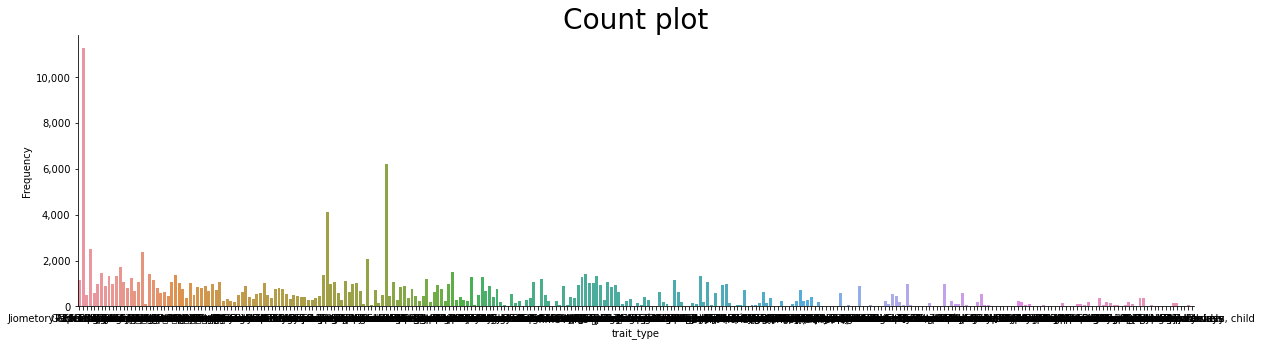

In [72]:
barchar_bucket(df_sales_final,'trait_type')

In [73]:
def histo_plot(ds,n,p,b,cols=list):

    # Identify all numeric variables in the dataset
    numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

    # Draw
    fig, ax = plt.subplots(n,p, figsize=(18,4))
    for var, subplot in zip(ds[cols], ax.flatten()):
        g = sns.histplot(data=ds,
                    bins=b,
                     x=var,
                     ax=subplot,
                     kde=True)

    # Decoration
    sns.despine()
    plt.rc('axes', labelsize=subPlots_label_fontSize)
    fig.suptitle("Histograms of all premium variables", fontsize=plots_Title_fontSize)

In [74]:
# Violin Plot
def violin_plot(ds,cols,hue_col,width,height, hue=False):

    for var in cols:
        if hue is False:
            fig = px.violin(ds, y=var, box=True, points= False)
        else:
            fig = px.violin(ds, y=var, box=True, points= False, color=hue_col)

        fig.update_layout(height=height, width=width, title_text='Violin Plot of '+ var, template = "plotly_white")
        fig.show()
        

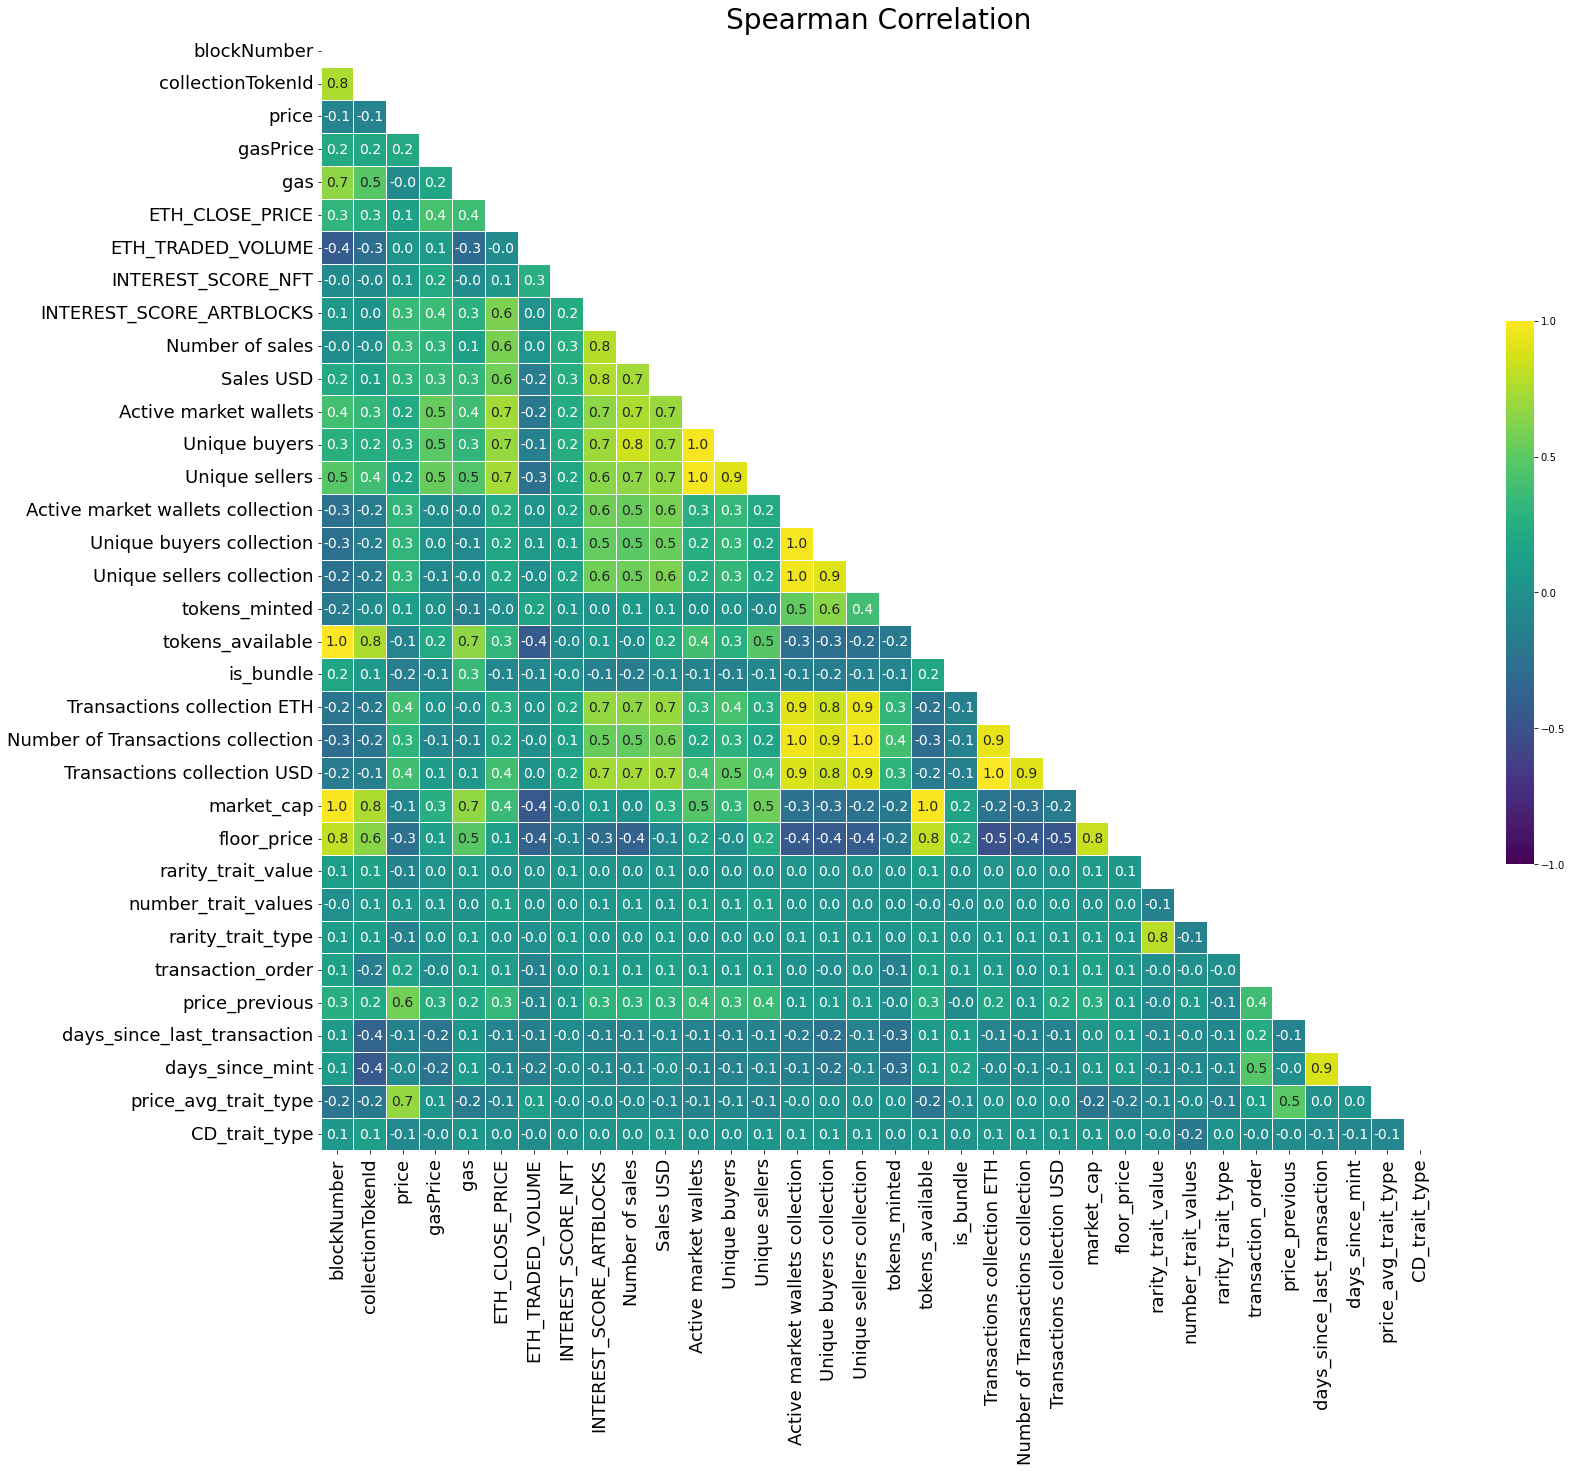

In [75]:
# CORRELATION

# Create correlation matrix
corr = df_sales_final.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(25, 25))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'viridis',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.1f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman Correlation", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)
ax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [76]:
# Get correlated features
c = df_sales_final.corr(method='spearman').abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so = so[so > 0.5]
so.sort_values(ascending=False,inplace=True)
df_so = pd.DataFrame(so)
df_so = df_so.reset_index()
df_so = df_so[df_so['level_0']!=df_so['level_1']]
df_so.drop_duplicates(subset=[0],inplace=True)
df_so

,level_0,level_1,0
34,blockNumber,tokens_available,0.999936
36,Number of Transactions collection,Unique sellers collection,0.992600
38,Transactions collection USD,Transactions collection ETH,0.987200
40,tokens_available,market_cap,0.978549
42,market_cap,blockNumber,0.978486
...,...,...,...
178,Unique buyers collection,INTEREST_SCORE_ARTBLOCKS,0.522614
180,Number of sales,Number of Transactions collection,0.517899
182,Active market wallets collection,tokens_minted,0.513769
184,Transactions collection ETH,floor_price,0.511297


In [77]:
'''# CORRELATION

# Create correlation matrix
corr = df_model_final.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(25, 25))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'viridis',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.1f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman Correlation", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)
ax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})'''

'# CORRELATION\n\n# Create correlation matrix\ncorr = df_model_final.corr(method=\'spearman\')\nmask = np.zeros_like(corr, dtype=np.bool)\nmask[np.triu_indices_from(mask)]= True\n\n# Draw\nfig , ax = plt.subplots(figsize=(25, 25))\nheatmap = sns.heatmap(corr,\n                      mask = mask,\n                      square = True,\n                      linewidths = .5,\n                      cmap = \'viridis\',\n                      cbar_kws = {\'shrink\': .4,\n                                \'ticks\' : [-1, -.5, 0, 0.5, 1]},\n                      fmt=\'.1f\',\n                      vmin = -1,\n                      vmax = 1,\n                      annot = True,\n                      annot_kws = {\'size\': heatmaps_text_fontSize})\n\n# Decoration\nplt.title("Spearman Correlation", fontsize=plots_Title_fontSize)\nax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)\nax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)\nsns.set_style({\'xtick.bottom\': True}, {\'ytic

In [78]:
def scatter_matrix(title,ds,cols,hue_col,hue=False):
    
    if hue is False:
        fig = px.scatter_matrix(ds,dimensions=cols)        
    else:
        fig = px.scatter_matrix(ds,dimensions=cols,color=hue_col)
    
    fig.update_layout(height=1200, width=1200, title_text='Scatter Matrix - '+title)#, template = "plotly_white")
    fig.show()

In [79]:
df_sales_final.columns

Index(['blockNumber', 'DATETIME', 'from', 'to', 'txHash', 'collectionTokenId',
       'hash', 'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT', 'INTEREST_SCORE_ARTBLOCKS',
       'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers', 'Active market wallets collection',
       'Unique buyers collection', 'Unique sellers collection',
       'tokens_minted', 'tokens_available', 'Action', 'is_bundle',
       'Transactions collection ETH', 'Number of Transactions collection',
       'Transactions collection USD', 'market_cap', 'floor_price',
       'trait_type', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'transaction_order', 'price_previous',
       'days_since_last_transaction', 'days_since_mint',
       'price_avg_trait_type', 'CD_trait_type'],
      dtype='object')

## Feature Selection

In [87]:
# Add date features
df_sales_final['DATE_WEEKDAY'] = df_sales_final['DATE'].dt.weekday
df_sales_final['DATE_MONTH'] = df_sales_final['DATE'].dt.month
df_sales_final['DATE_YEAR'] = df_sales_final['DATE'].dt.year

final_columns =  ['DATE_WEEKDAY','DATE_MONTH','DATE_YEAR','DATEYEAR','DATE','CD_trait_type',
                  'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','price', 'gasPrice',
                  'tokens_available','ETH_TRADED_VOLUME','ETH_CLOSE_PRICE','Sales USD','Active market wallets', #delta
                 'Transactions collection USD','Unique buyers collection','Unique sellers collection', #delta
                 'rarity_trait_value', 'number_trait_values','rarity_trait_type','trait_type',
                 'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers', 'Unique sellers'
                 ,'is_bundle','transaction_order', 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
                 , 'floor_price', 'market_cap']

delta_cols = ['ETH_TRADED_VOLUME','ETH_CLOSE_PRICE','Sales USD','Active market wallets', #delta
                 'Transactions collection USD','Unique buyers collection','Unique sellers collection','tokens_available',
             'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers','Unique sellers'
             , 'floor_price', 'market_cap']

In [89]:
df_sales_final['DATEYEAR'] = df_sales_final['DATE_YEAR']
df_model = df_sales_final[final_columns]
df_model.sort_values(by='DATE',inplace=True)


# Add year dummies
df_model = pd.get_dummies(df_model, columns=['DATE_YEAR'])

## Get delta data
df_delta = df_model[['DATE'] + delta_cols].drop_duplicates()
df_delta.sort_values(by='DATE',inplace=True)

df_delta_1 = df_delta.copy()
df_delta_1.index = df_delta_1.DATE 

df_delta_1 = df_delta_1.shift(periods=1)
df_delta_1.DATE = df_delta_1.index
df_delta_1.reset_index(drop=True,inplace=True)

df_delta = df_delta.merge(df_delta_1, how='left', on=['DATE'], suffixes=('', '_1'),indicator=False)
#df_delta.fillna(0,inplace=True)

deltas = []
for col in delta_cols:
    deltas.append(col+'_DELTA')
        
    for i in range(0,df_delta.index.max()+1):
        #print(i,col)
        t = df_delta.loc[i,col]
        t_1 = df_delta.loc[i,col+'_1']
        if i==0:
            pass
        else:
            df_delta.loc[i,col+'_DELTA'] = (t - t_1)/t_1
            

# Add deltas to main dataset
df_model_ = df_model.merge(df_delta[['DATE']+deltas], how='left', on=['DATE'], suffixes=('', ''),indicator=False)
df_model_.dropna(inplace=True)
df_model_.sort_values(by='DATE',inplace=True)

# Filter the deltas
final_columns_ =  ['DATE_WEEKDAY','DATE_MONTH','DATE','DATEYEAR','DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022',
                  'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','price', 'gasPrice','is_bundle',
                 'rarity_trait_value', 'number_trait_values','rarity_trait_type'
                  ,'transaction_order', 'price_previous','days_since_last_transaction', 'days_since_mint',
                   'price_avg_trait_type', 'floor_price', 'market_cap'
                  ] + deltas
df_model_final = df_model_[final_columns_]
df_model_final.sort_values(by='DATE',inplace=True)

In [92]:
df_model

,DATE_WEEKDAY,DATE_MONTH,DATEYEAR,DATE,CD_trait_type,INTEREST_SCORE_NFT,INTEREST_SCORE_ARTBLOCKS,price,gasPrice,tokens_available,...,transaction_order,price_previous,days_since_last_transaction,days_since_mint,price_avg_trait_type,floor_price,market_cap,DATE_YEAR_2020,DATE_YEAR_2021,DATE_YEAR_2022
64539,6,12,2020,2020-12-13,77.0,10.5,33.0,0.490000,6.300000e-08,5761.0,...,1,0.0500,0,0,2.305096,0.000,5.504244e+07,1,0,0
64721,6,12,2020,2020-12-13,77.0,10.5,33.0,0.199560,8.880000e-08,5761.0,...,1,0.0500,0,0,2.305096,0.000,5.504244e+07,1,0,0
64744,6,12,2020,2020-12-13,77.0,10.5,33.0,0.220000,5.200000e-08,5761.0,...,1,0.0500,0,0,2.305096,0.000,5.504244e+07,1,0,0
64473,6,12,2020,2020-12-13,77.0,10.5,33.0,0.063737,3.400000e-08,5761.0,...,1,0.0500,0,0,2.305096,0.000,5.504244e+07,1,0,0
64746,6,12,2020,2020-12-13,77.0,10.5,33.0,0.120000,5.100000e-08,5761.0,...,1,0.0500,0,0,2.305096,0.000,5.504244e+07,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14077,3,6,2022,2022-06-30,26.0,22.0,21.0,0.748450,5.963965e-08,188401.0,...,2,0.4400,219,226,0.756898,0.031,2.321630e+10,0,0,1
49575,3,6,2022,2022-06-30,166.0,22.0,21.0,0.150000,2.947805e-08,188401.0,...,1,0.1200,32,32,1.381574,0.031,2.321630e+10,0,0,1
47845,3,6,2022,2022-06-30,166.0,22.0,21.0,0.180000,6.975161e-08,188401.0,...,2,0.2000,84,84,1.381574,0.031,2.321630e+10,0,0,1
63236,3,6,2022,2022-06-30,247.0,22.0,21.0,1.400000,4.604667e-08,188401.0,...,2,0.9666,335,450,2.004576,0.031,2.321630e+10,0,0,1


In [93]:
df_model_final

,DATE_WEEKDAY,DATE_MONTH,DATE,DATEYEAR,DATE_YEAR_2020,DATE_YEAR_2021,DATE_YEAR_2022,INTEREST_SCORE_NFT,INTEREST_SCORE_ARTBLOCKS,price,...,Unique buyers collection_DELTA,Unique sellers collection_DELTA,tokens_available_DELTA,Number of Transactions collection_DELTA,Active market wallets collection_DELTA,Number of sales_DELTA,Unique buyers_DELTA,Unique sellers_DELTA,floor_price_DELTA,market_cap_DELTA
97748,0,11,2021-11-08,2021,0,1,0,26.0,73.0,11.1000,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
97751,0,11,2021-11-08,2021,0,1,0,26.0,73.0,0.0050,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
97752,0,11,2021-11-08,2021,0,1,0,26.0,73.0,1.0000,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
97753,0,11,2021-11-08,2021,0,1,0,26.0,73.0,0.3861,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
97754,0,11,2021-11-08,2021,0,1,0,26.0,73.0,0.6000,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148887,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.1500,...,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688,0.0,0.044988
148888,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.1800,...,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688,0.0,0.044988
148836,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.1900,...,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688,0.0,0.044988
148784,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.5000,...,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688,0.0,0.044988


_________

## Modeling

### OLS

In [ ]:
# No delta variables
df_ols = df_model.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']

X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE',
       'Sales USD', 'Active market wallets', 
       'Transactions collection USD', 'Unique buyers collection',
            'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers', 'Unique sellers', #
       'Unique sellers collection', 'tokens_available',
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle'
            , 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()


In [ ]:
# both delta and non delta variables
df_ols = df_model_.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']
X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME_DELTA', 'ETH_CLOSE_PRICE_DELTA',
       'Sales USD_DELTA', 'Active market wallets_DELTA',
       'Transactions collection USD_DELTA', 'Unique buyers collection_DELTA',
       'Unique sellers collection_DELTA', 'tokens_available_DELTA',
    'Number of Transactions collection_DELTA','Active market wallets collection_DELTA','Number of sales_DELTA','Unique buyers_DELTA', 'Unique sellers_DELTA', #
        'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE',
       'Sales USD', 'Active market wallets', 
       'Transactions collection USD', 'Unique buyers collection',
       'Unique sellers collection', 'tokens_available' ,  
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle',
             'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()

In [9]:
# Only delta variables

df_ols = df_model_final.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']
X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME_DELTA', 'ETH_CLOSE_PRICE_DELTA',
       'Sales USD_DELTA', 'Active market wallets_DELTA',
    'Number of Transactions collection_DELTA','Active market wallets collection_DELTA','Number of sales_DELTA','Unique buyers_DELTA', 'Unique sellers_DELTA', #            
       'Transactions collection USD_DELTA', 'Unique buyers collection_DELTA',
       'Unique sellers collection_DELTA', 'tokens_available_DELTA',
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle'
            , 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()

NameError: name 'df_model_final' is not defined

________________

### Machine Learning

In [100]:
def split_data(df,cols):
    
    df_ = df[cols]
    
    X = df_.drop(columns=['price'])
    y = df_['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=16)#, stratify=X['DATEYEAR'])
    
    #X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=16, stratify=X_test_['DATEYEAR'])
    
    return df_, X, y, X_train, X_test, y_train, y_test#, X_val, y_val

In [101]:
from sklearn.model_selection import TimeSeriesSplit

def split_ts(df,cols):
    
    df_ = df[cols]

    test_size = int(round(len(df_)*0.20,0))
    size = int(len(df_) - test_size)
    test = df_.iloc[-test_size:]
    train = df_.iloc[:size]

    
    X_train = train.drop(columns=['price'])
    X_test = test.drop(columns=['price'])
    y_train = train['price']
    y_test = test['price']
    
    #X_train.reset_index(drop=True,inplace=True)
    #X_test.reset_index(drop=True,inplace=True)
    #y_train.reset_index(drop=True,inplace=True)
    #y_test.reset_index(drop=True,inplace=True)
    
        
    return df_, X_train, X_test, y_train, y_test#, X_val, y_val

In [102]:
cols = ['DATE_WEEKDAY', 'DATE_MONTH','DATEYEAR','CD_trait_type',
       'INTEREST_SCORE_NFT', 'INTEREST_SCORE_ARTBLOCKS', 'price', 'gasPrice',
       'tokens_available', 'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE', 'Sales USD',
       'Active market wallets', 'Transactions collection USD',
       'Unique buyers collection', 'Unique sellers collection',
       'rarity_trait_value', 'number_trait_values', 'rarity_trait_type',
       'Number of Transactions collection',
       'Active market wallets collection', 'Number of sales', 'Unique buyers',
       'Unique sellers', 'is_bundle', 'transaction_order', 'price_previous',
       'days_since_last_transaction', 'days_since_mint','floor_price','market_cap',
       'price_avg_trait_type']
df_model.reset_index(drop=True,inplace=True)
#df_model_ml, X, y, X_train, X_test, y_train, y_test = split_data(df_model,cols)
df_model_ml, X_train, X_test, y_train, y_test = split_ts(df_model,cols)

In [103]:
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as ltb
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostRegressor

from matplotlib import pyplot
 

In [104]:
# Build class to store models and parameters

from skopt.space import Real, Categorical, Integer


class classification_models:
    def __init__(self):
        self.baseline = self.baseline()
        self.svc = self.svc()
        self.naive_bayes = self.naive_bayes()
        self.knn = self.knn()
        self.logistic_regression = self.logistic_regression()
        self.xgboost = self.xgboost()
        self.ada = self.ada()
        self.lgb = self.lgb()
        self.dt = self.dt()
        self.rf = self.rf()



class knn:
    model = KNeighborsRegressor()

    parameters = {'model__n_neighbors': Integer(3, 100),
                  'model__weights': Categorical(categories=['uniform', 'distance']),
                  'model__algorithm': Categorical(categories=['auto', 'ball_tree', 'kd_tree', 'brute']),
                  'model__leaf_size': Integer(5, 50)
                  }

    @staticmethod
    def best_model(params):
        clf = KNeighborsRegressor()
        return clf

    
class dt:
    model = DecisionTreeRegressor()

    parameters = {
                   'model__max_depth': Integer(2, 100),
                   'model__min_samples_leaf': Integer(2, 100),
                   'model__min_samples_split': Integer(2, 100),
                   'model__random_state': [16],
                 }

    @staticmethod
    def best_model(params):
        clf = DecisionTreeRegressor()
        return clf   
    
    
class rf:
    model = RandomForestRegressor()

    parameters = {
                   'model__max_depth': Integer(2, 100),
                   'model__min_samples_leaf': Integer(2, 100),
                   'model__min_samples_split': Integer(2, 100),
                   'model__n_estimators': Integer(10, 500),
                   'model__random_state': [16],
                 }

    @staticmethod
    def best_model(params):
        clf = RandomForestRegressor()
        return clf    


class xgboost:
    model = xgb.XGBRegressor()

    parameters = {
                   'model__learning_rate': Real(0.01,1.0,'uniform'),
                   'model__max_depth': Integer(2, 100),
                   'model__min_samples_leaf': Integer(2, 100),
                   'model__min_samples_split': Integer(2, 100),
                   'model__subsample': Real(0.1,1.0,'uniform'),
                   'model__n_estimators': Integer(10, 500),
                   'model__random_state': [16],
                 }


    @staticmethod
    def best_model(params):
        clf = xgb.XGBRegressor(**params)
        return clf


class ada:
    model = AdaBoostRegressor()

    parameters = {
                   'model__learning_rate': Real(0.01,1.0,'uniform'),
                   'model__n_estimators': Integer(10, 500),
                   'model__random_state': [16],
                 }


    @staticmethod
    def best_model(params):
        clf = AdaBoostRegressor(**params)
        return clf
    
class lgb:
    model = ltb.LGBMRegressor()

    parameters = {
                   'model__learning_rate': Real(0.01,1.0,'uniform'),
                   'model__max_depth': Integer(2, 100),
                   'model__min_samples_leaf': Integer(2, 100),
                   'model__min_samples_split': Integer(2, 100),
                   'model__subsample': Real(0.1,1.0,'uniform'),
                   'model__n_estimators': Integer(10, 500),
                   'model__random_state': [16],
                 }


    @staticmethod
    def best_model(params):
        clf = ltb.LGBMRegressor(**params)
        return clf

In [ ]:
# Function to build models
def build_model(X,y,niter,model_list=list):
    '''model_list = [baseline, svc, naive_bayes, knn, logistic_regression, xgboost]'''
    gsearchs = []
    best_models = []
    scores = []
    best_params = []
    cv_results = []
    
    print('---------------- MODEL TRAINING ----------------')
    
    for i in model_list:
        
        string = str(i)
        model_name_ = string[string.find('.')+1:]
        model_name = model_name_[0:model_name_.find('>')-1].strip()       
        print('\nModel: ', model_name)
        
        # Get model
        model = i.model
        
        # Import RFE
        #select = RFE(model, n_features_to_select=5, step=1)
        if model_name in ['rf', 'ada', 'xgboost']:
            select = RFECV(estimator=DecisionTreeRegressor(), step=1, min_features_to_select=10,scoring='neg_mean_squared_error')
        else:
            select = RFECV(model, min_features_to_select=10,scoring='neg_mean_squared_error')
        #select = SelectKBest(f_classif, k=10)
        
        # Create pipeline
        pipe = Pipeline([('scaler', MinMaxScaler()),('selector', select),('model',model)])
        #pipe = Pipeline([('scaler', MinMaxScaler()),('model',model)])
        #pipe = Pipeline([('model',model)])
    
        # Get hyperparameter grid
        param_search = i.parameters
        
        # Stratified k-fold cross-validation
        #skf = StratifiedKFold(n_splits=5)
        #skf = KFold(n_splits=8)
        skf = TimeSeriesSplit(n_splits=10)
        my_cv = [(train,test) for train, test in skf.split(X,y)]
        
        gsearch = BayesSearchCV(pipe, cv=skf, search_spaces=param_search, n_jobs=-1,scoring='neg_mean_squared_error',
                                     verbose=True,refit=True,n_iter=niter)
        
        
        gsearch.fit(X, y)
        
        
        gsearchs.append(gsearch)
        best_models.append(gsearch.best_estimator_)
        scores.append(gsearch.best_score_)
        best_params.append(gsearch.best_params_)
        cv_results.append(gsearch.cv_results_)
        
        print('CV accuracy for model {0}: {1}'.format(model_name,gsearch.best_score_))
        
    return gsearchs,best_models,scores,best_params,cv_results

model_list = [dt, rf, lgb, ada, xgboost]
gsearchs,best_models,scores,best_params,cv_results = build_model(X_train,y_train, 50,model_list)

---------------- MODEL TRAINING ----------------

Model:  dt
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [ ]:
# Get best model feature stats
ad = []
for i in range(0,len(gsearchs)):
    #print(gsearchs[1])
    print(i)
    d = {'support': gsearchs[i].best_estimator_['selector'].get_support(indices=False),
        'ranking': gsearchs[i].best_estimator_['selector'].ranking_
        }

    selected_features = pd.DataFrame(d, index = X_train.columns)
    selected_features.sort_values(by=['ranking'],inplace = True)
    selected_features['model'] = i

    print('Number of Features: ', [gsearchs[i].best_estimator_['selector'].n_features_in_])
    print('Number of Features in: ', [gsearchs[i].best_estimator_['selector'].n_features_])
    print('Features in: ', selected_features[selected_features['support']==True].index.tolist())

    ad.append(selected_features)
    print('______________________________________________________________________')
    
features = pd.concat(ad)
features

In [ ]:
gsearchs[1]

In [ ]:
print(scores)

In [ ]:
### ---------------------------- PERFORMANCE ASSESSEMENT ----------------------------### 
# Function to evaluate models
def evaluate_model(X_test, X_train,y_train, y_test, best_models):
    
    mae_,mse_,mape_,r_,r_adj_,pred_ = list(),list(),list(),list(),list(),list()
    
    print('---------------- MODEL EVALUATION ----------------')
    
    model_counter = 1
    for i in best_models:
        
        string = str(i)
        model_name_ = string[string.find(''''model',''')+len(''''model', '''):]
        model_name = model_name_[0:model_name_.find('(')].strip() 
        print('\nModel #{0}: {1}'.format(model_counter,model_name))
        
        # Predict
        y_pred = i.predict(X_test)        
        df_pred = pd.DataFrame(data=y_pred, columns=['y_hat'],index=y_test.index)
        df_pred['y'] = y_test
        df_pred['model'] = model_name        
        
        # Evaluation metrics     
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r = r2_score(y_test, y_pred)
        #Adj_r2 = 1 - (1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y)-X_test.shape[1]-1)
        
        print('MAPE: ', mape)
        print('MAE: ', mae)
        print('MSE: ', mse)  
        print('R2: ', r)

        mae_.append(mae)
        mape_.append(mape)
        mse_.append(mse)
        r_.append(r)
        pred_.append(df_pred)
        
        model_counter+=1
    
    # Get best model based on MSE
    maxi_model_nb = mse_.index(min(mse_))
    
    maxi_model = best_models[maxi_model_nb]
    string_ = str(maxi_model)
    maxi_model_name_ = string_[string_.find(''''model',''')+len(''''model', '''):]
    maxi_model_name = maxi_model_name_[0:maxi_model_name_.find('(')].strip() 
    predictions = pd.concat(pred_)
    
    
    print('\nBest Model: #{0} {1}'.format(maxi_model_nb+1,maxi_model_name))
    
    
    return mae_,mse_,mape_,r_, maxi_model, predictions

In [ ]:
mae,mse,mape,r,maxi_model, predictions_train = evaluate_model(X_train, X_train, y_train, y_train, best_models)

In [ ]:
mae,mse,mape,r,maxi_model,predictions_test = evaluate_model(X_test, X_train, y_train, y_test, best_models)

In [ ]:
predictions_test

In [ ]:
predictions_train[predictions_train['y']==1000]

In [ ]:
##### DEBUG #####
a = df_transactions[df_transactions['collectionTokenId']==78000313]
a.sort_values(by='DATETIME', ascending=True,inplace=True)
a

#df_transactions[df_transactions['DATE']==pd.to_datetime('2020-12-13')]